<a href="https://colab.research.google.com/github/highonhues/ProtNet/blob/main/ProtNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ProtNet: A geometrically sound Graph Neural Network (GNN) to identify Protein - Ligand Interactions


This project involves building a Graph Neural Network$^{[1][2]}$ to predict binding affinity of Protein - Ligand groups. Alongwith atomic and chemical features of proteins and ligands, this project displays protein and ligand atoms as spatial coordinates$^{[3]}$ and calculates the Euclidean distances between them.

Dependencies

1.Numpy

2.PyTorch

3.RDKit

4.SciPy

5.BioPython

6.Pandas

7.Matplotlib

8.NetworkX

In [ ]:
!pip install rdkit-pypi biopython #this sometimes throws an error which can be corrected by simply running the code cell again.

In [ ]:
from rdkit import Chem #this sometimes throws an error which can be corrected by simply running the code cell again.
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit import RDLogger
from Bio.PDB import PDBParser
from scipy.spatial.distance import pdist, squareform

In [ ]:
import os, math, time, random, shutil
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx

##Dataset:

[PDBbind](http://www.pdbbind.org.cn/) is a database composed of all the binding affinity of molecules present in the Protein Data Bank, hence the name. The type of dataset we use here is the 2020 version of the Protein - Ligand [Refined](http://www.pdbbind.org.cn/download.php) dataset. With a file size of 658MB, it is comprised of around 5316 complexes. The proteins are in PDB format, a standard textual format housing its amino acid sequence, coordinates, atomic type etc. The ligands are in Mol2 ( standard molecular properties ) and Structure DatA File/SDF ( format of type of bond and connectivity of ligands ) formats. These files were created by a special computer and then manually curated by experts. They are very important in molecular docking experiments.

For the targets, we downloaded the [PDBv2020 index](http://pdbbind.org.cn/download.php) file to get the binding affinities corresponding to the PDB protein files in the refined set. We used a simple awk command [ **awk '!/^#/ {printf "%s,%.2f\n", $1, $4}' INDEX_refined_data.2020 > refined_labels.csv** ] to extract the pdb_ids and binding affinities into a csv files - refined_labels.csv.

In [ ]:
!wget http://www.pdbbind.org.cn/download/pdbbind_v2020_refined.tar.gz

--2025-05-15 20:37:37--  http://www.pdbbind.org.cn/download/pdbbind_v2020_refined.tar.gz
Resolving www.pdbbind.org.cn (www.pdbbind.org.cn)... 47.98.218.30
Connecting to www.pdbbind.org.cn (www.pdbbind.org.cn)|47.98.218.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 690895072 (659M) [application/x-gzip]
Saving to: ‘pdbbind_v2020_refined.tar.gz’

pdbbind_v2020_refin  18%[==>                 ] 124.00M  1.23MB/s    in 2m 45s  

2025-05-15 20:40:22 (771 KB/s) - Connection closed at byte 130023424. Retrying.

--2025-05-15 20:40:23--  (try: 2)  http://www.pdbbind.org.cn/download/pdbbind_v2020_refined.tar.gz
Connecting to www.pdbbind.org.cn (www.pdbbind.org.cn)|47.98.218.30|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 690895072 (659M), 560871648 (535M) remaining [application/x-gzip]
Saving to: ‘pdbbind_v2020_refined.tar.gz’

pdbbind_v2020_refin  37%[+++===>             ] 248.00M   856KB/s    in 2m 18s  

2025-05-15 20:42:41 

In [ ]:
!mkdir -p /content/refined_data #creating new directory to store the dataset
!tar -xzf pdbbind_v2020_refined.tar.gz -C /content/refined_data

In [ ]:
from google.colab import files #uploading the refined_labels.csv which contains the binding affinities.
uploaded = files.upload()

Saving refined_labels.csv to refined_labels.csv


In [ ]:
!sed -i '1i pdb_id,affinity' refined_labels.csv #attaching column headers

##Methods:

###-> Data Preprocessing

A. Refined labels csv is loaded, missing values are coerced and dropped. This is done to maintain good ground-truth of binding affinity values.

B. The Refined dataset is cleaned up ensuring complexes containing valid PDB ids and ligand .mol2/sdf files are retained. They are also cross checked with the PDB_IDs corresponding to the label_map dictionary to ensure they have valid binding affinity. This is done to filter out missing/unlabelled data that will not be of value when predicting with an MSE metric. Around 5316 compounds were identified.

C. Ligand parsing is carried out with RDKit library that helps load the ligand file (.mol2 here). After Hydrogen addition and Gasteiger charge computation and coordinate extraction, they are sorted into 2D feature and 3D coords numpy arrays respectively. Protein parsing is carried out similarly with dummy charges (to ensure consistency across arrays). Water and unknown heteroatoms are removed as well.

D. Raw coordinates are converted into graph tensors that are digestible by the GNN. The nodes are ligand/protein atoms and the distances between them are the edges. A visualization of graph network between protein and ligand-atoms of one PDB_ID (6hlx) is done with NetworkX and Matplotlib libraries.

E. The cleaned up dataset with corresponding binding affinity labels is split as 70/15/15 for train/validate/test as per standard.


In [ ]:
# hide RDKit warnings
RDLogger.DisableLog("rdkit.MolOps")

# hyper-parameters & paths
DATA_ROOT= Path("/content/refined_data") #protein-ligand refined dataset
LABEL_CSV= Path("/content/refined_labels.csv") #target labels according to PDB IDs
MAX_COMPLEX = 300 #number of complexes to use
EPOCHS = 7 #number of training iterations
CUTOFF= 5.0 #Å-radius for building edges (all atom pairs ≤ CUTOFF become edges)
LR = 5e-4 # learning-rate for Adam optimizer
HIDDEN = 32 # width of the hidden/node feature vector
SEED = 42 #seed for reproducibility

#seeds set for reproducibility

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

##DEMO CELL

In [ ]:
from google.colab import files #uploading the refined_labels.csv which contains the binding affinities.
uploaded = files.upload()

Saving pdbbind_subset.tar.gz to pdbbind_subset.tar (1).gz


In [ ]:
!mkdir -p /content/refined_data #creating new directory to store the dataset
!tar -xzf pdbbind_subset.tar.gz -C /content/refined_data

In [ ]:
########## DEMOCELL #####################
# hide RDKit warnings
RDLogger.DisableLog("rdkit.MolOps")

# hyper-parameters & paths
DATA_ROOT= Path("/content/refined_data") #protein-ligand refined dataset
LABEL_CSV= Path("/content/refined_labels.csv") #target labels according to PDB IDs
MAX_COMPLEX = 20 #number of complexes to use
EPOCHS = 3 #number of training iterations
CUTOFF= 5.0 #Å-radius for building edges (all atom pairs ≤ CUTOFF become edges)
LR = 5e-4 # learning-rate for Adam optimizer
HIDDEN = 32 # width of the hidden/node feature vector
SEED = 42 #seed for reproducibility

#seeds set for reproducibility

################ DATA PREPROCESSING ######################################
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
label_df = pd.read_csv(LABEL_CSV, dtype={"pdb_id": str}) #keeps pdb as string
label_df['affinity'] = pd.to_numeric(label_df['affinity'], errors='coerce') #coercing bad datapoints to NAN values
label_df.dropna(subset=["affinity"], inplace=True) #dropping NAN/missing binding affinities
label_map = {pid.lower(): float(pk) for pid, pk in zip(label_df.pdb_id, label_df.affinity)} # creates a dictionary with pdb_ids as keys and their affinities as value pairs
print(f"Loaded {len(label_map)} affinity labels") #total number of complexes as binding affinity is unique

def scan_complexes(root: Path): #function that goes through the refined set and only picks out chemical compounds with a valid affinity, pdb and ligand file
    base =root / "pdbbind_subset"
    out = []
    for d in sorted(base.iterdir()):
        if not d.is_dir(): continue
        pid = d.name.lower() #done to ensure no case variations and future errors
        if pid not in label_map: continue
        prot =d / f"{pid}_protein.pdb"
        lig  =next((d / f"{pid}_ligand{ext}" for ext in (".mol2",".sdf")
                     if (d / f"{pid}_ligand{ext}").exists()),
                    None)
        if prot.exists() and lig:
            out.append({"pdb_id": pid, "protein": prot, "ligand": lig}) #list of dictionaries in the form of { "pdb_id": str, "protein": Path, "ligand": Path }
    return out

all_complexes= scan_complexes(DATA_ROOT)
random.shuffle(all_complexes) #randomly shuffles complexes
complexes= all_complexes[:MAX_COMPLEX] #this takes the subset as specified by the MAX_COMPLEX parameter above
print(f"Using {len(complexes)} complexes")

# 70/15/15 split of train/validate/test
n_tr = int(0.70 * len(complexes))
n_va =int(0.15* len(complexes))
train_set =complexes[:n_tr]
val_set =complexes[n_tr :n_tr + n_va]
test_set =complexes[n_tr + n_va :]
print(f"Split: train {len(train_set)} | val {len(val_set)}  | test {len(test_set)}") #number of datapoints per set

def _valid(e):
    try: return Chem.GetPeriodicTable().GetAtomicNumber(e.capitalize()) > 0 #identifies chemical elements according to the periodic table
    except:
      return False

def parse_ligand(path: Path):
    ''' Handles heterogenous file formats .mol2 and .sdf
    ,missing hydrogen charges,
     and inconsistent naming while getting coordinates'''

    if path.suffix.lower()==".mol2": #loads ligand file, the file type is .mol2
        mol= Chem.MolFromMol2File(str(path), sanitize=False,removeHs=False)
    else:
        mol= Chem.MolFromMolFile(str(path),sanitize=False,removeHs=False)

    if mol is None: #checks for empty ligands
        return np.zeros((0, 3), np.float32),np.zeros((0, 2),np.float32)

    mol =Chem.AddHs(mol)
    try:
        AllChem.ComputeGasteigerCharges(mol)
    except Exception:
        return np.zeros((0, 3), np.float32), np.zeros((0, 2), np.float32)

    conf =mol.GetConformer() #gets ligand atom coordinates
    coords, feats = [], []
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())

        # Gasteiger charges sometimes NaN or inf
        #adding H and clamping invalid vals for stable features
        charge = 0.0
        if atom.HasProp("_GasteigerCharge"): #pulls Gasteiger charges
            try:
                charge =float(atom.GetProp("_GasteigerCharge"))
            except ValueError:
                charge = 0.0
        if math.isnan(charge) or math.isinf(charge):
            charge = 0.0

        coords.append([pos.x, pos.y, pos.z])
        feats .append([atom.GetAtomicNum(), charge])


    return np.asarray(coords, np.float32), np.asarray(feats, np.float32) #returns 2 numpy arrays of coordinates and features of ligand atoms


def parse_protein(path: Path):

    prot =PDBParser(QUIET=True).get_structure("p", str(path))
    coords,feats =[],[]
    for mol in prot: #molecule
        for ch in mol: #chain
            for res in ch: #residue
                if res.get_resname().strip() in {"HOH","WAT","UNK"}: #stripping water out so that we only have protein remaining
                  continue
                for atom in res: #atom
                    sym=atom.element.strip().capitalize()
                    if not _valid(sym):
                      continue
                    coords.append(atom.coord.tolist())
                    feats.append([Chem.GetPeriodicTable().GetAtomicNumber(sym), 0.0])#dummy charge of 0.0 added to ensure same dimension as the ligand array
    return np.asarray(coords, np.float32), np.asarray(feats, np.float32) #2 numpy arrays of coordinates and features of protein

def build_graph(lc, lf, pc, pf, r=CUTOFF): #this function creates a graph tensor between protein and ligand where the nodes are their respecitve feature arrays
    nc =np.concatenate([lc, pc])
    nf =np.concatenate([lf, pf])
    D = squareform(pdist(nc)) #pairwise distances calculated
    mask= (D<=r)&(D>0) #cutoff maintained as per paper
    src, dst= np.where(mask)
    edge_idx = np.stack([src, dst]).astype(np.int64)
    dist =D[src, dst] #gets the actual distances per edge
    return {
        "node_feats": torch.tensor(nf, dtype=torch.float32),
        "edge_index": torch.from_numpy(edge_idx),
        "edge_dist":  torch.tensor(dist[:,None], dtype=torch.float32),
    }

def to_device(g, dev): #this functions ensures tensors will be on the GPU (where the model also is)
    mem ={}
    for k, v in g.items():
        mem[k] = v.to(dev).float() if v.is_floating_point() else v.to(dev)
    return mem

Loaded 5316 affinity labels
Using 20 complexes
Split: train 14 | val 3  | test 3


##DEMO CELL

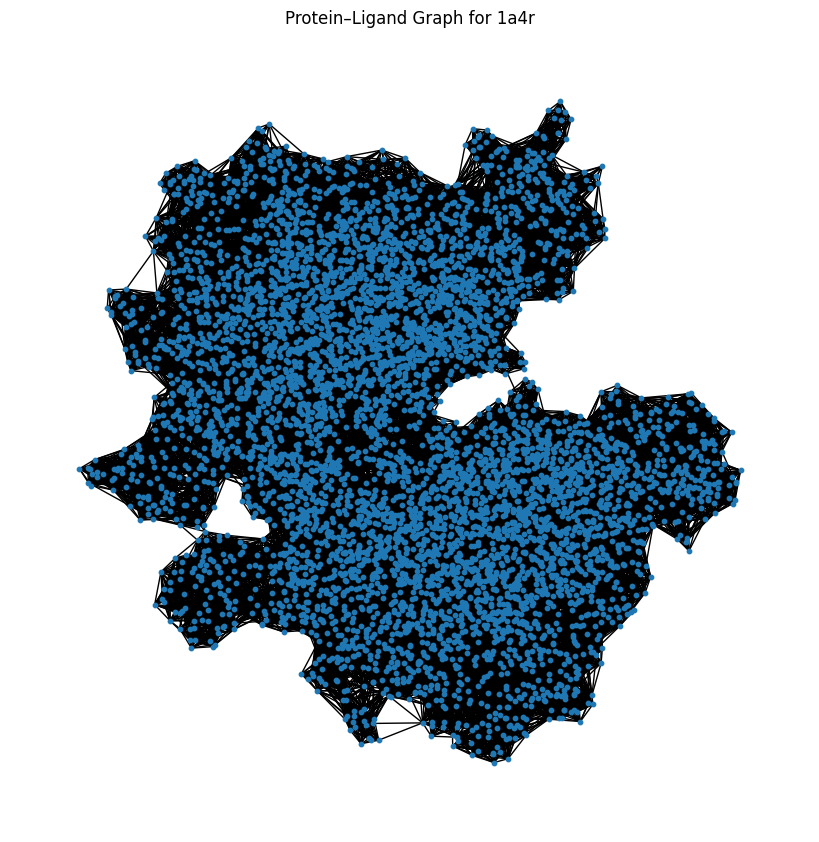

In [ ]:
################# DEMO VISUALIZATION ################################################
BASE_DIR = Path("/content/refined_data/pdbbind_subset") #we have used saved subset

complex_dirs =sorted([d for d in BASE_DIR.iterdir() if d.is_dir()]) #finds complex with both ligand and protein present
for d in complex_dirs:
    lig = next((d / f"{d.name}_ligand{ext}" for ext in (".mol2", ".sdf")
                if (d / f"{d.name}_ligand{ext}").exists()),
               None)
    prot = d / f"{d.name}_protein.pdb"
    if lig and prot.exists():
        ligand_path= lig
        protein_path = prot
        pdb_id = d.name
        break

lc, lf =parse_ligand(ligand_path) #parses ligand
pc, pf =parse_protein(protein_path) #parses protein
g= build_graph(lc, lf, pc, pf) #builds graph

node_coords = np.vstack([lc, pc]) #node coordinates are constructed

n_g = nx.Graph() #creates NetworkX graph
for i, (x, y, z) in enumerate(node_coords):
    n_g.add_node(i, pos=(x, y))

edges= g["edge_index"].t().cpu().numpy()
for src, dst in edges:
    n_g.add_edge(int(src), int(dst))

plt.figure(figsize=(8, 8)) #plots the NetworkX graph for one PDB_ID
pos = nx.get_node_attributes(n_g, 'pos')
nx.draw(n_g, pos, node_size=10, with_labels=False)
plt.title(f"Protein–Ligand Graph for {pdb_id}")
plt.axis("off")
plt.show()

##DEMO CELL

Starting training


run_epoch: 100%|████████████████████████| 3/3 [01:39<00:00, 33.27s/it]


Epoch 1 | train MSE 10.0849 | val MSE 23.5783


run_epoch: 100%|████████████████████████| 3/3 [01:38<00:00, 32.85s/it]


Epoch 2 | train MSE 7.3029 | val MSE 13.0714


run_epoch: 100%|████████████████████████| 3/3 [01:40<00:00, 33.58s/it]


Epoch 3 | train MSE 6.6830 | val MSE 12.1211


run_epoch: 100%|████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


Test MSE on 3 complexes: 10.5666


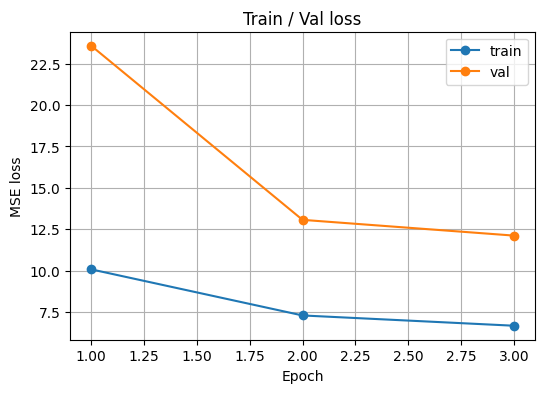

In [ ]:
class Node2Edge(nn.Module):
    def __init__(self, nd, gd, h): #nd- node features composed of charges and atomic number, gd - distance, h- hyperparameter which is the hidden width
        super().__init__()
        self.fc = nn.Linear(2*nd + gd, h)
    def forward(self, x, ei, g):
        s,d = ei
        return F.relu(self.fc(torch.cat([x[s],x[d],g], dim=-1))) #produces a edge feature tensor of shape (E,h)

class Edge2Node(nn.Module): #takes input from Node2Edge layer
    def __init__(self, nd, ed,h):
        super().__init__()
        self.fc = nn.Linear(nd + ed,h)
    def forward(self, x, e, ei, N):
        sum = torch.zeros(N,e.size(1), device=x.device).index_add_(0, ei[1], e) #sum of the incoming features before sending to next node
        return F.relu(self.fc(torch.cat([x, sum], dim=-1)))

class PGAL(nn.Module): #polar graph attention layer
    def __init__(self,nd=2,gd=1, h=HIDDEN):
        super().__init__()
        self.n2e = Node2Edge(nd,gd,h)
        self.e2n = Edge2Node(nd,h,h)
    def forward(self, g):
        e = self.n2e(g["node_feats"], g["edge_index"], g["edge_dist"]) #g is the dictionary with the respective keys
        n = self.e2n(g["node_feats"], e, g["edge_index"], g["node_feats"].size(0))
        return n #node features have shape (N,h)

class Net(nn.Module): #pgal-mean pool-linear regression head
    def __init__(self):
        super().__init__()
        self.pgal = PGAL()
        self.head = nn.Linear(HIDDEN, 1)
    def forward(self, g):
        x = self.pgal(g)
        gvec = x.mean(dim=0, keepdim=True)
        return self.head(gvec) #outputs one value - binding affinity


#Train / Validate / Test
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
opt= optim.Adam(model.parameters(), lr=LR)

train_hist, val_hist = [], []
print("Starting training")

def run_epoch(dataset, train=False): #single loop for train and validate set per epoch to ensure gold standard of deep neural network training/validation
    model.train() if train else model.eval()
    total, count = 0.0, 0

    for c in tqdm(dataset, desc="run_epoch", ncols=70):
        #parses for ligand
        try:
            out_l = parse_ligand(c["ligand"])
            if not isinstance(out_l, tuple) or len(out_l) != 2:
                continue
            lc, lf = out_l
        except Exception:
            continue
        try:
            out_p = parse_protein(c["protein"])  #parses protein
            if not isinstance(out_p, tuple) or len(out_p) != 2:
                continue
            pc, pf = out_p
        except Exception:
            continue

        #skips empties
        if any(x is None for x in (lc, lf, pc, pf)):
            continue
        g =build_graph(lc, lf, pc, pf)  #build graph tensors and moves to gpu
        g=to_device(g, device)

        y =torch.tensor([label_map[c["pdb_id"]]], #target labels are converted to float tensor
                         dtype=torch.float32, device=device)

        with torch.set_grad_enabled(train):   #forward (both train and validation)
            pred = model(g).view(-1)
            loss = F.mse_loss(pred, y)
            if train:
                opt.zero_grad() #backward propogation only for training set
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                opt.step()
        total+= loss.item()
        count += 1

    return (total / count) if count else float("nan") #outputs mean loss for the dataset, NAN outputted if nothing




####################################### RUNNING THE GNN MODEL #############################################################################
for epoch in range(1, EPOCHS + 1):
    tr =run_epoch(train_set, train=True) #training pass
    vl =run_epoch(val_set,train=False) #validation pass
    train_hist.append(tr) #updating metrics for train
    val_hist.append(vl) #updating validation metrics
    print(f"Epoch {epoch} | train MSE {tr:.4f} | val MSE {vl:.4f}")

test_mse = run_epoch(test_set, train=False) #run on test dataset
print(f"Test MSE on {len(test_set)} complexes: {test_mse:.4f}") #printing out final test MSE metric


########################################################## PLOTTING MSE CURVE ###############################################
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, EPOCHS+1), train_hist, marker='o', label='train')
plt.plot(range(1, EPOCHS+1), val_hist,   marker='o', label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE loss'); plt.title('Train / Val loss')
plt.legend(); plt.grid(True); plt.show() #line plot to check MSE change of Train vs. Validation Loss




##END OF DEMO

In [ ]:
label_df = pd.read_csv(LABEL_CSV, dtype={"pdb_id": str}) #keeps pdb as string
label_df['affinity'] = pd.to_numeric(label_df['affinity'], errors='coerce') #coercing bad datapoints to NAN values
label_df.dropna(subset=["affinity"], inplace=True) #dropping NAN/missing binding affinities
label_map = {pid.lower(): float(pk) for pid, pk in zip(label_df.pdb_id, label_df.affinity)} # creates a dictionary with pdb_ids as keys and their affinities as value pairs
print(f"Loaded {len(label_map)} affinity labels") #total number of complexes as binding affinity is unique

def scan_complexes(root: Path): #function that goes through the refined set and only picks out chemical compounds with a valid affinity, pdb and ligand file
    base =root / "refined-set"
    out = []
    for d in sorted(base.iterdir()):
        if not d.is_dir(): continue
        pid = d.name.lower() #done to ensure no case variations and future errors
        if pid not in label_map: continue
        prot =d / f"{pid}_protein.pdb"
        lig  =next((d / f"{pid}_ligand{ext}" for ext in (".mol2",".sdf")
                     if (d / f"{pid}_ligand{ext}").exists()),
                    None)
        if prot.exists() and lig:
            out.append({"pdb_id": pid, "protein": prot, "ligand": lig}) #list of dictionaries in the form of { "pdb_id": str, "protein": Path, "ligand": Path }
    return out

all_complexes= scan_complexes(DATA_ROOT)
random.shuffle(all_complexes) #randomly shuffles complexes
complexes= all_complexes[:MAX_COMPLEX] #this takes the subset as specified by the MAX_COMPLEX parameter above
print(f"Using {len(complexes)} complexes")

# 70/15/15 split of train/validate/test
n_tr = int(0.70 * len(complexes))
n_va =int(0.15 * len(complexes))
train_set =complexes[:n_tr]
val_set =complexes[n_tr :n_tr + n_va]
test_set =complexes[n_tr + n_va :]
print(f"Split: train {len(train_set)} | val {len(val_set)}  | test {len(test_set)}") #number of datapoints per set


Loaded 5316 affinity labels
Using 300 complexes
Split → train 210 | val 45 | test 45


In [ ]:
def _valid(e):
    try: return Chem.GetPeriodicTable().GetAtomicNumber(e.capitalize()) > 0 #identifies chemical elements according to the periodic table
    except:
      return False

def parse_ligand(path: Path):
    ''' Handles heterogenoud file formats .mol2 and .sdf
    ,missing hydrogen charges,
     and inconsistent naming while getting coordinates'''

    if path.suffix.lower()==".mol2": #loads ligand file, the file type is .mol2
        mol= Chem.MolFromMol2File(str(path), sanitize=False,removeHs=False)
    else:
        mol= Chem.MolFromMolFile(str(path),sanitize=False,removeHs=False)

    if mol is None: #checks for empty ligands
        return np.zeros((0, 3), np.float32),np.zeros((0, 2),np.float32)

    mol =Chem.AddHs(mol)
    try:
        AllChem.ComputeGasteigerCharges(mol)
    except Exception:
        return np.zeros((0, 3), np.float32), np.zeros((0, 2), np.float32)

    conf =mol.GetConformer() #gets ligand atom coordinates
    coords, feats = [], []
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())

        # Gasteiger charges sometimes NaN or inf
        #adding H and clamping invalid vals for stable features
        charge = 0.0
        if atom.HasProp("_GasteigerCharge"): #pulls Gasteiger charges
            try:
                charge =float(atom.GetProp("_GasteigerCharge"))
            except ValueError:
                charge = 0.0
        if math.isnan(charge) or math.isinf(charge):
            charge = 0.0

        coords.append([pos.x, pos.y, pos.z])
        feats .append([atom.GetAtomicNum(), charge])


    return np.asarray(coords, np.float32), np.asarray(feats, np.float32) #returns 2 numpy arrays of coordinates and features of ligand atoms


def parse_protein(path: Path):

    prot =PDBParser(QUIET=True).get_structure("p", str(path))
    coords,feats =[],[]
    for mol in prot: #molecule
        for ch in mol: #chain
            for res in ch: #residue
                if res.get_resname().strip() in {"HOH","WAT","UNK"}: #stripping water out so that we only have protein remaining
                  continue
                for atom in res: #atom
                    sym=atom.element.strip().capitalize()
                    if not _valid(sym):
                      continue
                    coords.append(atom.coord.tolist())
                    feats.append([Chem.GetPeriodicTable().GetAtomicNumber(sym), 0.0])#dummy charge of 0.0 added to ensure same dimension as the ligand array
    return np.asarray(coords, np.float32), np.asarray(feats, np.float32) #2 numpy arrays of coordinates and features of protein

def build_graph(lc, lf, pc, pf, r=CUTOFF): #this function creates a graph tensor between protein and ligand where the nodes are their respecitve feature arrays
    nc =np.concatenate([lc, pc])
    nf =np.concatenate([lf, pf])
    D = squareform(pdist(nc)) #pairwise distances calculated
    mask= (D<=r)&(D>0) #cutoff maintained as per paper
    src, dst= np.where(mask)
    edge_idx = np.stack([src, dst]).astype(np.int64)
    dist     = D[src, dst] #gets the actual distances per edge
    return {
        "node_feats": torch.tensor(nf, dtype=torch.float32),
        "edge_index": torch.from_numpy(edge_idx),
        "edge_dist":  torch.tensor(dist[:,None], dtype=torch.float32),
    }

def to_device(g, dev): #this functions ensures tensors will be on the GPU (where the model also is)
    mem ={}
    for k, v in g.items():
        mem[k] = v.to(dev).float() if v.is_floating_point() else v.to(dev)
    return mem


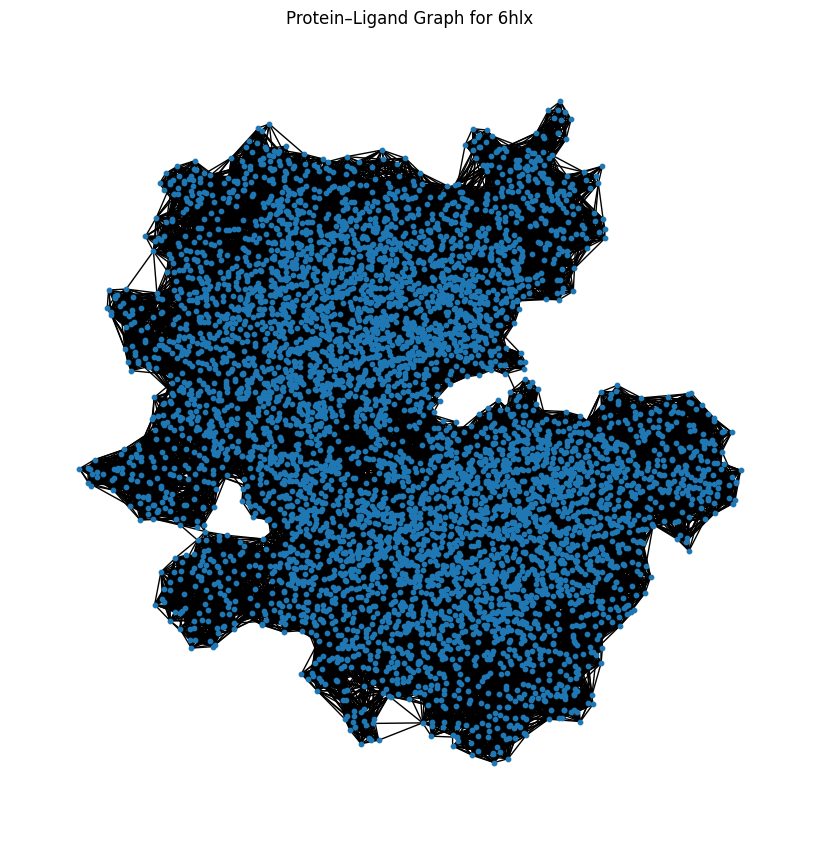

In [ ]:
BASE_DIR = Path("/content/pdbbind_subset") #we have used saved subset

complex_dirs =sorted([d for d in BASE_DIR.iterdir() if d.is_dir()]) #finds complex with both ligand and protein present
for d in complex_dirs:
    lig = next((d / f"{d.name}_ligand{ext}" for ext in (".mol2", ".sdf")
                if (d / f"{d.name}_ligand{ext}").exists()),
               None)
    prot = d / f"{d.name}_protein.pdb"
    if lig and prot.exists():
        ligand_path= lig
        protein_path = prot
        pdb_id = d.name
        break

lc, lf =parse_ligand(ligand_path) #parses ligand
pc, pf =parse_protein(protein_path) #parses protein
g= build_graph(lc, lf, pc, pf) #builds graph

node_coords = np.vstack([lc, pc]) #node coordinates are constructed

n_g = nx.Graph() #creates NetworkX graph
for i, (x, y, z) in enumerate(node_coords):
    n_g.add_node(i, pos=(x, y))

edges= g["edge_index"].t().cpu().numpy()
for src, dst in edges:
    n_g.add_edge(int(src), int(dst))

plt.figure(figsize=(8, 8)) #plots the NetworkX graph for one PDB_ID
pos = nx.get_node_attributes(n_g, 'pos')
nx.draw(n_g, pos, node_size=10, with_labels=False)
plt.title(f"Protein–Ligand Graph for 6hlx")
plt.axis("off")
plt.show()

### -> Model Architecture

The model is a small scale PGAL graph-neural network.
Each forward pass performs one Node→Edge→Node block that fuses the two end node vectors with their inter-atomic distance (edges). Global mean-pooling updates node embeddings.
A single linear head maps this pooled graph vector to a scalar binding-affinity prediction.


== LABEL DF SAMPLE ==
  pdb_id  affinity
0   2r58       2.0
1   3c2f       2.0
2   3g2y       2.0
3   3pce       2.0
4   4qsu       2.0 

== SPLIT SIZES ==
 train: 210
   val: 45
  test: 45

== USING PDB ID = 6hlx AS EXAMPLE ==
Ligand coords shape: (38, 3)
Ligand feats shape: (38, 2)
Protein coords shape: (4677, 3)
Protein feats shape: (4677, 2)

GRAPH SAMPLE:
  # nodes:    4715
  # edges:    136312
  edge_dist:  torch.Size([136312, 1]) 

Protein coords shape: (4677, 3)
Protein feats shape: (4677, 2)

GRAPH SAMPLE:
  # nodes: 4715
  # edges: 136312
  edge_dist: torch.Size([136312, 1]) 

Starting training …


run_epoch: 100%|██████████████████████| 45/45 [00:34<00:00,  1.31it/s]


Epoch 1 | train MSE 7.2332 | val MSE 8.5865


run_epoch: 100%|██████████████████████| 45/45 [00:34<00:00,  1.31it/s]


Epoch 2 | train MSE 5.6242 | val MSE 5.4668


run_epoch: 100%|██████████████████████| 45/45 [00:34<00:00,  1.31it/s]


Epoch 3 | train MSE 5.2171 | val MSE 4.1176


run_epoch: 100%|██████████████████████| 45/45 [00:34<00:00,  1.29it/s]


Epoch 4 | train MSE 5.1375 | val MSE 3.4860


run_epoch: 100%|██████████████████████| 45/45 [00:34<00:00,  1.30it/s]


Epoch 5 | train MSE 5.2927 | val MSE 3.7003


run_epoch: 100%|██████████████████████| 45/45 [00:36<00:00,  1.24it/s]


Epoch 6 | train MSE 5.4713 | val MSE 3.7198


run_epoch: 100%|██████████████████████| 45/45 [00:35<00:00,  1.28it/s]


Epoch 7 | train MSE 5.5932 | val MSE 3.8189


run_epoch: 100%|██████████████████████| 45/45 [01:24<00:00,  1.87s/it]


Test MSE on 45 complexes: 4.7782


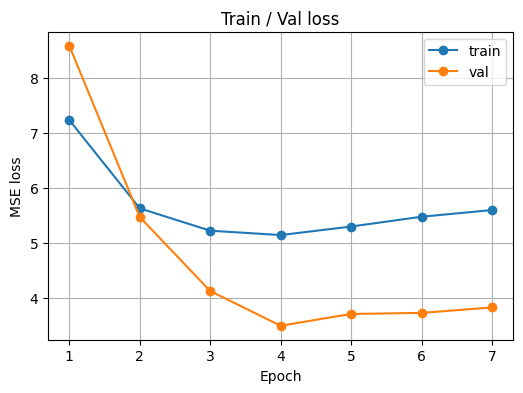

In [ ]:
class Node2Edge(nn.Module):
    def __init__(self, nd, gd, h): #nd- node features composed of charges and atomic number, gd - distance, h- hyperparameter which is the hidden width
        super().__init__()
        self.fc = nn.Linear(2*nd + gd, h)
    def forward(self, x, ei, g):
        s,d = ei
        return F.relu(self.fc(torch.cat([x[s],x[d],g], dim=-1))) #produces a edge feature tensor of shape (E,h)

class Edge2Node(nn.Module): #takes input from Node2Edge layer
    def __init__(self, nd, ed,h):
        super().__init__()
        self.fc = nn.Linear(nd + ed,h)
    def forward(self, x, e, ei, N):
        sum = torch.zeros(N,e.size(1), device=x.device).index_add_(0, ei[1], e) #sum of the incoming features before sending to next node
        return F.relu(self.fc(torch.cat([x, sum], dim=-1)))

class PGAL(nn.Module): #polar graph attention layer
    def __init__(self,nd=2,gd=1, h=HIDDEN):
        super().__init__()
        self.n2e = Node2Edge(nd,gd,h)
        self.e2n = Edge2Node(nd,h,h)
    def forward(self, g):
        e = self.n2e(g["node_feats"], g["edge_index"], g["edge_dist"]) #g is the dictionary with the respective keys
        n = self.e2n(g["node_feats"], e, g["edge_index"], g["node_feats"].size(0))
        return n #node features have shape (N,h)

class Net(nn.Module): #pgal-mean pool-linear regression head
    def __init__(self):
        super().__init__()
        self.pgal = PGAL()
        self.head = nn.Linear(HIDDEN, 1)
    def forward(self, g):
        x = self.pgal(g)
        gvec = x.mean(dim=0, keepdim=True)
        return self.head(gvec) #outputs one value - binding affinity

#checks for fully processed compounds in the train, test and validate set
print("\n== LABEL DF SAMPLE ==")
print(label_df.head(), "\n") #prints top 5 complexes
print("== SPLIT SIZES ==")
print(f"train:{len(train_set)}")
print(f"val:{len(val_set)}")
print(f"test:{len(test_set)}\n")

pass_eg = None
for c in complexes:
    out_l = parse_ligand(c["ligand"])
    out_p = parse_protein(c["protein"])
    if (isinstance(out_l, tuple) and len(out_l)==2
     and isinstance(out_p, tuple) and len(out_p)==2
     and all(v is not None for v in out_l + out_p)):
        good_example = c
        l_coords, l_feats = out_l
        p_coords, p_feats = out_p
        break

if pass_eg is None:
    print("No fully parsable complex in subset")
else:
    print("== USING PDB ID =", good_example["pdb_id"], "AS EXAMPLE ==")
    print("Ligand coords shape:",l_coords.shape)
    print("Ligand feats shape:",l_feats.shape)
    print("Protein coords shape:",p_coords.shape)
    print("Protein feats shape:", p_feats.shape)

    # build & inspect one graph
    g = build_graph(l_coords, l_feats, p_coords, p_feats)
    print("\nGRAPH SAMPLE:")
    print(" # nodes: ", g["node_feats"].shape[0])
    print(" # edges: ", g["edge_index"].shape[1])
    print(" edge_dist:", g["edge_dist"].shape, "\n")

p_coords, p_feats = parse_protein(pass_eg['protein'])
print("Protein coords shape:", None if p_coords is None else p_coords.shape)
print("Protein feats shape:",None if p_feats  is None else p_feats.shape)


#Train / Validate / Test
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
opt= optim.Adam(model.parameters(), lr=LR)

train_hist, val_hist = [], []
print("Starting training")

def run_epoch(dataset, train=False): #single loop for train and validate set per epoch to ensure gold standard of deep neural network training/validation
    model.train() if train else model.eval()
    total, count = 0.0, 0

    for c in tqdm(dataset, desc="run_epoch", ncols=70):
        #parses for ligand
        try:
            out_l = parse_ligand(c["ligand"])
            if not isinstance(out_l, tuple) or len(out_l) != 2:
                continue
            lc, lf = out_l
        except Exception:
            continue
        try:
            out_p = parse_protein(c["protein"])  #parses protein
            if not isinstance(out_p, tuple) or len(out_p) != 2:
                continue
            pc, pf = out_p
        except Exception:
            continue

        #skips empties
        if any(x is None for x in (lc, lf, pc, pf)):
            continue
        g =build_graph(lc, lf, pc, pf)  #build graph tensors and moves to gpu
        g=to_device(g, device)

        y =torch.tensor([label_map[c["pdb_id"]]], #target labels are converted to float tensor
                         dtype=torch.float32, device=device)

        with torch.set_grad_enabled(train):   #forward (both train and validation)
            pred = model(g).view(-1)
            loss = F.mse_loss(pred, y)
            if train:
                opt.zero_grad() #backward propogation only for training set
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                opt.step()
        total+= loss.item()
        count += 1

    return (total / count) if count else float("nan") #outputs mean loss for the dataset, NAN outputted if nothing




####################################### RUNNING THE GNN MODEL #############################################################################
for epoch in range(1, EPOCHS + 1):
    tr =run_epoch(train_set, train=True) #training pass
    vl =run_epoch(val_set,train=False) #validation pass
    train_hist.append(tr) #updating metrics for train
    val_hist.append(vl) #updating validation metrics
    print(f"Epoch {epoch} | train MSE {tr:.4f} | val MSE {vl:.4f}")

test_mse = run_epoch(test_set, train=False) #run on test dataset
print(f"Test MSE on {len(test_set)} complexes: {test_mse:.4f}") #printing out final test MSE metric


########################################################## PLOTTING MSE CURVE ###############################################
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, EPOCHS+1), train_hist, marker='o', label='train')
plt.plot(range(1, EPOCHS+1), val_hist,   marker='o', label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE loss'); plt.title('Train / Val loss')
plt.legend(); plt.grid(True); plt.show() #line plot to check MSE change of Train vs. Validation Loss


# subset_root = Path("/content/pdbbind_subset") #this is the code we used to create demo subset
# if not subset_root.exists():
#     subset_root.mkdir(parents=True)
#     for x in complexes:
#         dst = subset_root / c["pdb_id"]
#         dst.mkdir(exist_ok=True)
#         shutil.copy(c["protein"], dst)
#         shutil.copy(c["ligand"],  dst)
#     pd.DataFrame(complexes).merge(label_df, on="pdb_id")[["pdb_id","affinity"]].to_csv(subset_root/"labels.csv", index=False)
#     os.system("tar -czf pdbbind_subset.tar.gz -C /content pdbbind_subset")

##Results

Our GNN model showed significant decrease in training (7.23 to 5.59) and validation (8.59 to 3.82) losses over 7 epochs.

Our final unseen test datset MSE was 4.78.Given that the affinities span roughly 2 – 11 pK units, an MSE of 4.78 (≈ RMSE 2.18) is better than a naïve baseline but is not state-of-the-art.The network is good at learning patterns however, there is room for improvement.


##References

[1] Li, Shuangli, et al. "Structure-aware interactive graph neural networks for the prediction of protein-ligand binding affinity." Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data mining. 2021.

[2] Jaechang Lim, Seongok Ryu, Kyubyong Park, Yo Joong Choe, Jiyeon Ham, and Woo Youn Kim. 2019. Predicting drug–target interaction using a novel graph neural network with 3D structure-embedded graph representation. Journal of chemical information and modeling 59, 9 (2019), 3981–3988.

[3] Tomasz Danel, Przemysław Spurek, Jacek Tabor, Marek Śmieja, Łukasz Struski, Agnieszka Słowik, and Łukasz Maziarka. 2020. Spatial graph convolutional networks. In International Conference on Neural Information Processing. Springer, 668–675.